# Code for Simulating Theta Sweeps and Phase Coding in Direction Cells

This repository provides the code used to generate **theta sweeps** and **theta phase coding** in direction cell models.

For empirical data and model details, please see:  
[Ji, Z., Lomi, E., Jeffery, K., Mitchell, A. S., & Burgess, N. (2025). *Phase Precession Relative to Turning Angle in Theta‐Modulated Head Direction Cells*. *Hippocampus, 35*(2), e70008.](https://onlinelibrary.wiley.com/doi/full/10.1002/hipo.70008)

---

*Created by **Zilong Ji**, UCL*


In [1]:
import numpy as np
import brainpy.math as bm

import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")

from sweep.network_models import DCNet, DCParams
from sweep import plotting

%matplotlib inline
%load_ext autoreload
%autoreload 2

bm.set_dt(1.)  #simulation time stamp 1 ms

In [2]:
def simulate_dcnet(net: DCNet, directions, velocity_gains, theta_strength=0, theta_cycle_len=100):
    """Simulate DCNet over a trajectory of directions and velocity gains."""
    def step(i, direction, velocity_gain):
        # theta oscillation phase
        t = i * bm.dt
        theta_phase = bm.mod(t, theta_cycle_len) / theta_cycle_len
        theta_phase = theta_phase * 2 * np.pi - np.pi

        # theta modulation
        theta_modulation = 1 + theta_strength * velocity_gain * bm.cos(theta_phase)

        # update network
        net.step_run(i, direction, theta_modulation)

        return net.center, net.r, theta_phase, theta_modulation

    return bm.for_loop(
        step,
        (bm.arange(len(directions)), directions, velocity_gains),
        progress_bar=True
    )


In [3]:
 # 1 ms

params = DCParams(adaptation_strength=10)
dc_net = DCNet(cell_num=100, params=params)   


cycleT = 2000 #2 seconds for a full rotation
numT = 30000 #15 cycles = 30 seconds

direction = 2* bm.pi * bm.arange(numT) / cycleT
direction = bm.mod(direction, 2*bm.pi) - bm.pi

direction_unwrapped = np.unwrap(direction)
#calculate angular speed
ang_velocity = bm.diff(direction_unwrapped) / bm.dt * 1000  # in deg/s
ang_velocity = bm.insert(ang_velocity, 0, 0)
velocity_gains = ang_velocity/np.max(np.abs(ang_velocity))

# simulate the DC network
internal_direction, net_activity, theta_phase, theta_modulation = simulate_dcnet(
    dc_net, direction, velocity_gains, theta_strength=1.0, theta_cycle_len=100
)

#to numpy array
internal_direction = np.array(internal_direction)
net_activity = np.array(net_activity)
theta_phase = np.array(theta_phase)
theta_modulation = np.array(theta_modulation)

2025-09-13 10:49:58.333539: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  0%|          | 0/30000 [00:00<?, ?it/s]

## Plot theta sweeps (population) and theta phase coding (single-cell) 

/tmp/ipykernel_4100165/2426979574.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


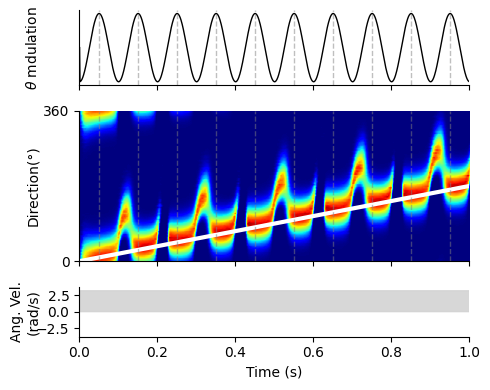

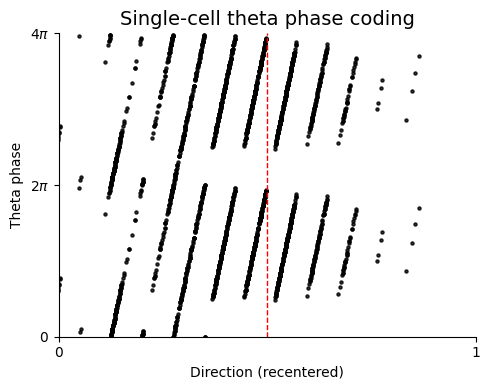

In [4]:
time_steps = np.arange(1, numT+1)/1000

fig, axes = plt.subplots(
    3,
    1,
    figsize=(5, 4),
    sharex=True,
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.5, 3, 1]},
    dpi=100,
)

ax = axes[0]
ax = plotting.plot_theta_modulation(ax, time_steps, theta_phase, theta_modulation, add_lines=True, atol=1e-2)

ax = axes[1]
ax = plotting.plot_population_activity(ax, time_steps, theta_phase, net_activity, direction, add_lines=True, atol=1e-2)

ax = axes[2]
ax = plotting.plot_angular_velocity(ax, time_steps, ang_velocity)


for ax in axes:
    sns.despine(ax=ax)
    #align ylabels vertically
    ax.yaxis.set_label_coords(-0.1, 0.5)  # Shift labels left (adjust as needed)
    #labelsize as 14
    ax.tick_params(axis='both', which='major', labelsize=10)
    #labelsize as 14
    ax.yaxis.label.set_size(10)
    ax.xaxis.label.set_size(10)
    ax.set_xlim(0,1)

plt.tight_layout()

cell_num = dc_net.cell_num

#check the phase coding of a single head direction cell

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=100)

# ax = plot_phaseprecession(ax, 10, bump_activity_downsampled, Actual_pos, theta_phase)

cell_index = 80

cell_activity = net_activity[:, cell_index]

plotting.plot_phase_coding(ax, cell_activity, direction, theta_phase, cell_index, cell_num)

sns.despine(ax=ax)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.label.set_size(10)
ax.xaxis.label.set_size(10)

plt.tight_layout()

### Note: You may notice that the simulated trajectory with constant speed produced phase coding. Apart from phase precession (not very significant; see below with a trajectory simulated with RatInABox, which is more significant), you can see several lines going upward. The number of lines matches the number of theta cycles. A previous paper (Sloin et al., 2022, JNS) called this theta phase rolling, but it might reflect several spikes elicited in each individual theta cycle (at least in the model). Therefore, one should be cautious when interpreting this pattern.

<img src="../figures/phaserolling_data.jpg" alt="theta phase rolling" width="30%"/>


## Now let's use RatInABox (George et al, 2024, eLife) to simulate some 'real' trajectories where the animal's head is keep rotating but with varying angular speed

/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/ratinabox/utils.py:891: UserWarning: Found 1 unexpected params key(s) while initializing Agent object: 'rotation_velocity_std'.
If you intended to set this parameter, ignore this message. To see all default parameters for this class call Agent.get_all_default_params().
  warnings.warn(
  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:10<00:00, 1978.78it/s]


    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


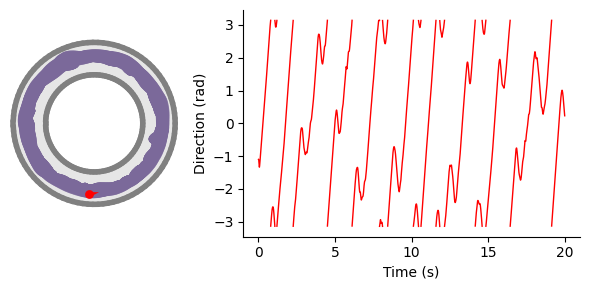

In [4]:
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from tqdm import tqdm

#We will create a circular environment with a circular hole in the center, so that head direction keeps changing. Cleaver and simple, right!
Env = Environment(
    params={
    'boundary':[[0.5*np.cos(t),0.5*np.sin(t)] for t in np.linspace(0,2*np.pi,100)],
    'holes':[[[0.3*np.cos(t),0.3*np.sin(t)] for t in np.linspace(0,2*np.pi,100)]],
    })

#dt is 1 ms
Ag = Agent(Env,params={'dt':0.001, 'speed_mean':3, 'speed_std':0.5, 'speed_coherence_time':0.08,
                      'rotation_velocity_std':180*np.pi/180, 'rotational_velocity_coherence_time':0.01})

simulate_time = 20 #seconds

Ag.pos = np.array([0.4,0]) #set initial position
for i in tqdm(range(int( simulate_time / Ag.dt))): 
    if i<100: #enforce anti-clockwise initial movement
        Ag.update(drift_velocity=10*np.array([-0.4,0.4])) #set initial velocity
    else: 
        Ag.update()

#get the head direction
direction_xy = Ag.history["head_direction"]
direction_xy = np.array(direction_xy)

#calculate the angle
direction = np.arctan2(direction_xy[:,1], direction_xy[:,0])
#calculate ang_velocity
# unwrap to remove jumps at -pi/pi
direction_unwrapped = np.unwrap(direction)
ang_velocity = np.diff(direction_unwrapped) / Ag.dt
ang_velocity = np.insert(ang_velocity, 0, 0)




#plot 
fig, axs = plt.subplots(1,2,figsize=(6,3),dpi=100, width_ratios=[1,2])

ax = axs[0]
Ag.plot_trajectory(fig=fig, ax=ax, framerate=1000)

ax = axs[1]
# find the jump points where the difference between two adjacent points is greater than pi
jumps = np.where(np.abs(np.diff(direction)) > np.pi)[0]
# set the jump points to NaN for plotting
direction_plot = direction.copy()
direction_plot[jumps + 1] = np.nan
time_steps = np.array(Ag.history["t"])  
ax.plot(time_steps, direction_plot, lw=1, color='red')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Direction (rad)')

sns.despine(ax=ax)

plt.tight_layout()



### simulate the network

In [5]:
params = DCParams(adaptation_strength=10, conn_noise=0)
dc_net = DCNet(cell_num=100, params=params)   

velocity_gains = np.abs(ang_velocity)/np.max(np.abs(ang_velocity))

# simulate the DC network
internal_direction, net_activity, theta_phase, theta_modulation = simulate_dcnet(
    dc_net, direction, velocity_gains, theta_strength=1, theta_cycle_len=100
)

internal_direction = np.array(internal_direction)
net_activity = np.array(net_activity)
theta_phase = np.array(theta_phase)
theta_modulation = np.array(theta_modulation)

  0%|          | 0/20000 [00:00<?, ?it/s]

(0.0, 4000.0)

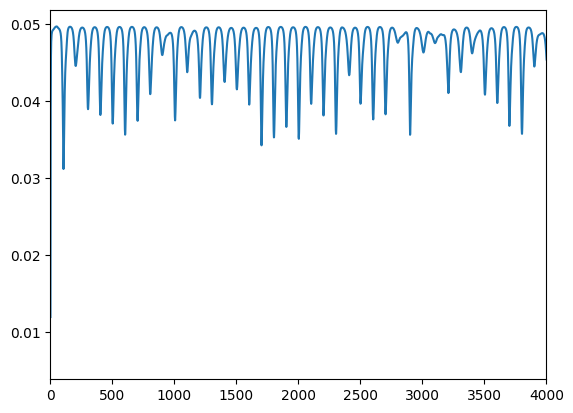

In [8]:
plt.plot(np.mean(net_activity, axis=1))
plt.xlim(0,4000)

### Let's plot theta sweeps and theta phase coding. 

/tmp/ipykernel_4100165/802880163.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


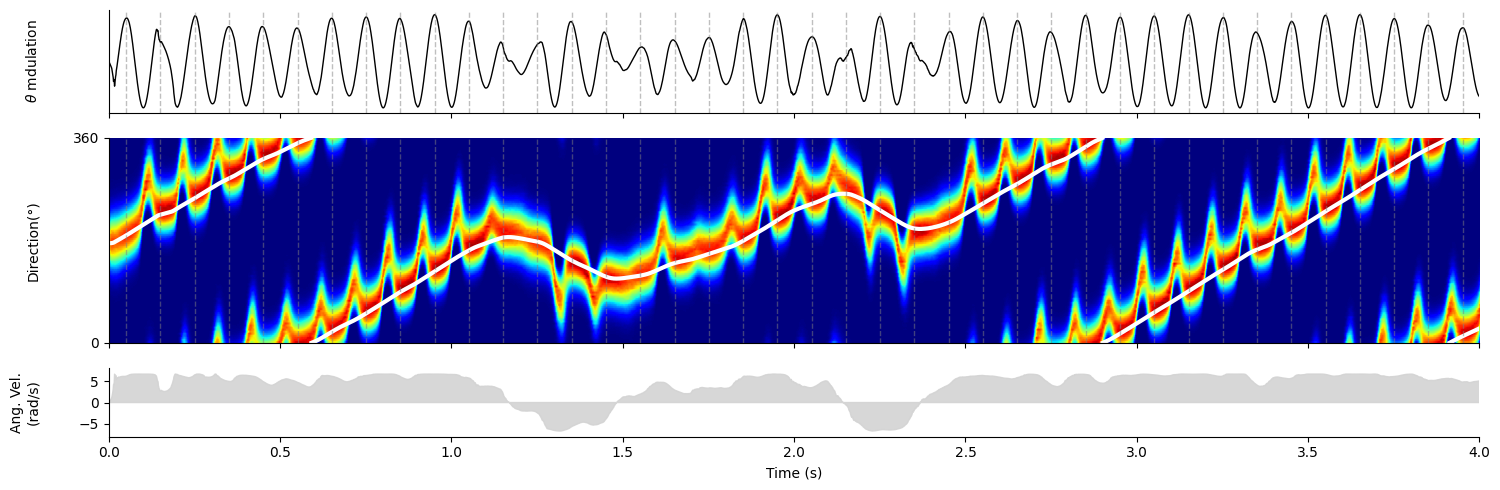

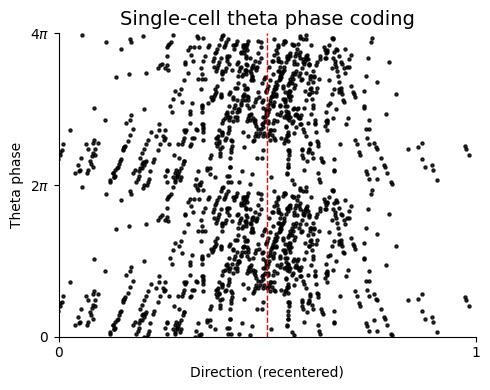

In [7]:
time_steps = np.array(Ag.history["t"])

fig, axes = plt.subplots(
    3,
    1,
    figsize=(15, 5),
    sharex=True,
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.5, 3, 1]},
    dpi=100,
)

ax = axes[0]
ax = plotting.plot_theta_modulation(ax, time_steps, theta_phase, theta_modulation, add_lines=True, atol=5e-2)

ax = axes[1]
ax = plotting.plot_population_activity(ax, time_steps, theta_phase, net_activity, direction, add_lines=True, atol=5e-2)

ax = axes[2]
ax = plotting.plot_angular_velocity(ax, time_steps, ang_velocity)


for ax in axes:
    sns.despine(ax=ax)
    #align ylabels vertically
    ax.yaxis.set_label_coords(-0.05, 0.5)  # Shift labels left (adjust as needed)
    #labelsize as 14
    ax.tick_params(axis='both', which='major', labelsize=10)
    #labelsize as 14
    ax.yaxis.label.set_size(10)
    ax.xaxis.label.set_size(10)
    ax.set_xlim(0,4)

plt.tight_layout()


#-------------------------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=100)

# ax = plot_phaseprecession(ax, 10, bump_activity_downsampled, Actual_pos, theta_phase)

cell_index = 80

cell_activity = net_activity[:, cell_index]

plotting.plot_phase_coding(ax, cell_activity, direction, theta_phase, cell_index, cell_num)

sns.despine(ax=ax)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.label.set_size(10)
ax.xaxis.label.set_size(10)

plt.tight_layout()

### This simple model predicts the existence of phase-coding head driection cells, which we reported in Ji & Lomi et al, 2025, Hippocampus. I showed examples of theta phase precession in four recorded head direction cells below. 
[Phase Precession Relative to Turning Angle in Theta-Modulated Head Direction Cells](https://onlinelibrary.wiley.com/doi/full/10.1002/hipo.70008)



<img src="../figures/phasecoding_tmHDC.jpg" alt="theta phase precession" width="50%"/>
